# Data Analysis

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline. 

We will discuss:

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

===================================================================================================

## Predicting Renting Price of Houses

The aim of the project is to build a machine learning model to predict the rent price of homes based on data obtained from the idealista API of real real estate listings in Lisbon.


### Why is this important? 

Predicting rent prices is useful to identify fruitful investments or to determine whether the price advertised for a house is over or under-estimated.


### What is the objective of the machine learning model?

We aim to minimise the difference between the real price and the price estimated by our model. We will evaluate model performance with the:

1. mean squared error (mse)
2. root squared of the mean squared error (rmse)
3. r-squared (r2).

# Data Analysis

Let's go ahead and import the necessary libraries

In [1]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# to display the plots in a nice way
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

Next, we load the dataset

In [2]:
# config
read_path = f"../../data/idealista"

city = "lisbon"
operation = "rent"
date_or_unioned = "unioned"
include_geodata = True
outlier_removal_method = None

In [3]:
def is_valid_date_format(date_string):
    try:
        datetime.datetime.strptime(date_string, "%Y-%m-%d")
        return True
    except ValueError:
        return False


if not (date_or_unioned == "unioned" or is_valid_date_format(date_or_unioned)):
    raise ValueError(
        "date_or_unioned must be 'unioned' or a valid date in the format 'YYYY-MM-DD'"
    )

# base file name
file_name = f"{date_or_unioned}-{city}-listings-for-{operation}"

if outlier_removal_method is not None:
    file_name += f"-{outlier_removal_method}"
if include_geodata:
    file_name += f"-with-geodata"

data = pd.read_csv(
    f"{read_path}/cleaned/{operation}/{city}/{file_name}.csv", index_col="propertyCode"
)

# rows and columns of the data
data.shape

FileNotFoundError: [Errno 2] No such file or directory: '../../data/idealista/cleaned/rent/lisbon/unioned-lisbon-listings-for-rent-with-geodata.csv'

In [ ]:
data.columns

Index(['thumbnail', 'externalReference', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'rooms', 'bathrooms', 'address',
       'province', 'municipality', 'district', 'country', 'latitude',
       'longitude', 'showAddress', 'url', 'distance', 'description',
       'hasVideo', 'status', 'newDevelopment', 'hasLift', 'priceByArea',
       'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour', 'has360',
       'hasStaging', 'topNewDevelopment', 'topPlus', 'neighborhood',
       'newDevelopmentFinished', 'snapshotDate', 'formerPrice', 'priceChange',
       'isPriceLowered', 'hasParkingSpace', 'isParkingSpaceIncludedInPrice',
       'parkingSpacePrice', 'totalPrice', 'distanceToNearestMall',
       'nearestMallName', 'distanceToNearestTrain', 'nearestTrainName',
       'distanceToNearestFair', 'nearestFairName', 'distanceToNearestPark',
       'nearestParkName', 'distanceToNearestMarket', 'nearestMarketName',
       'distanceToNearestMetro', 'nearestMetroName

The columns in this dataset are not all interesting so we will make a preliminary selection of columns:

In [ ]:
features = [
    "floor",
    "propertyType",
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "latitude",
    "longitude",
    "showAddress",
    "hasVideo",
    "status",
    "newDevelopment",
    "hasLift",
    "hasPlan",
    "has3DTour",
    "has360",
    "hasStaging",
    "topNewDevelopment",
    "topPlus",
    "newDevelopmentFinished",
    "isPriceLowered",
    "hasParkingSpace",
    "isParkingSpaceIncludedInPrice",
    "distanceToNearestMall",
    "nearestMallName",
    "distanceToNearestTrain",
    "nearestTrainName",
    "distanceToNearestFair",
    "nearestFairName",
    "distanceToNearestPark",
    "nearestParkName",
    "distanceToNearestMarket",
    "nearestMarketName",
    "distanceToNearestMetro",
    "nearestMetroName",
    "distanceToNearestViewpoint",
    "nearestViewpointName",
    "distanceToNearestPlayground",
    "nearestPlaygroundName",
]
target = ["totalPrice"]

In [ ]:
data = data[features + target]

In [ ]:
from sklearn.model_selection import train_test_split

# Let's separate into train and test set
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["municipality"])

In [ ]:
data_train.shape, data_test.shape

((2370, 41), (593, 41))

The house price dataset contains 2542 rows, that is, real estate listings, and 40 columns, i.e., variables.

## Analysis

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Discrete
    - Continuous
    - Distributions
    - Transformations

5. Categorical variables
    - Cardinality
    - Rare Labels
    - Special mappings
    
6. Additional Reading Resources

## Target

Let's begin by exploring the target distribution.

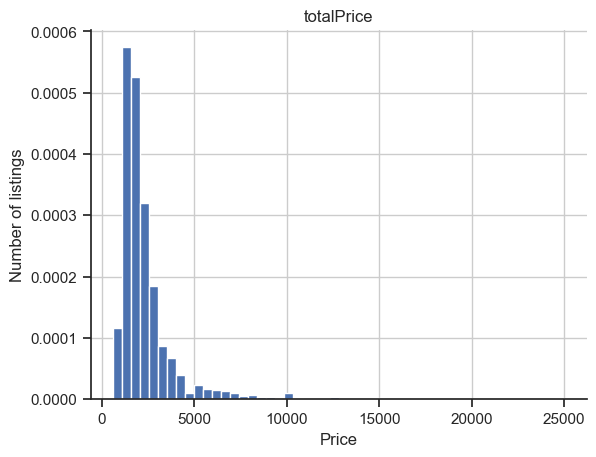

In [ ]:
# histogran to evaluate target distribution

data_train[target].hist(bins=50, density=True)
plt.ylabel('Number of listings')
plt.xlabel('Price')
plt.show()

We can see that the target is continuous, and the distribution is skewed towards the right.

We can improve the value spread with a mathematical transformation.

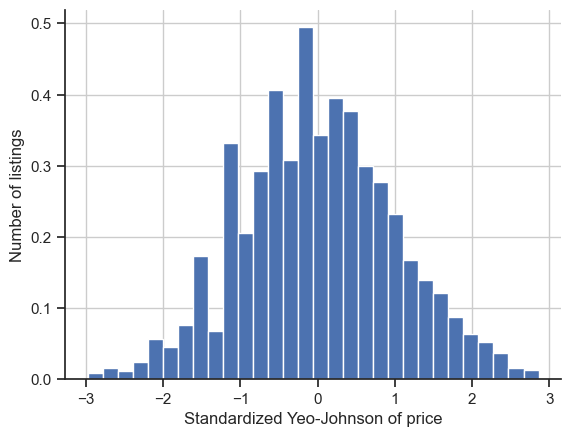

In [ ]:
from sklearn.preprocessing import PowerTransformer

temp = data_train.copy()
pt = PowerTransformer()
temp['totalPrice'] = pt.fit_transform(data_train[target].values.reshape(-1,1))
temp = temp[abs(temp['totalPrice']) <= 3]
temp['totalPrice'].hist(bins=30, density=True)
plt.ylabel('Number of listings')
plt.xlabel('Standardized Yeo-Johnson of price')
plt.show()


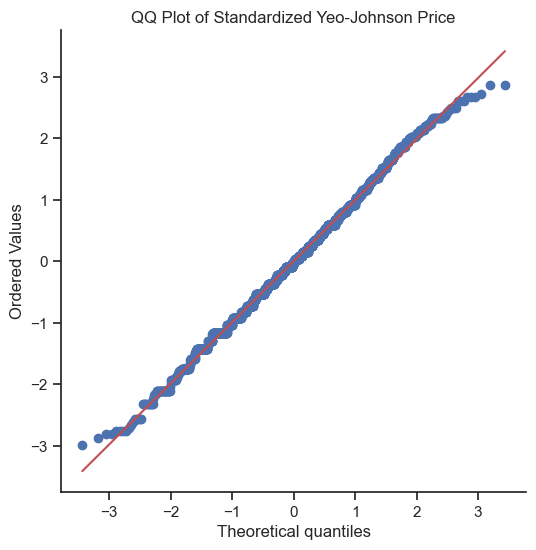

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
stats.probplot(temp["totalPrice"], dist="norm", plot=ax)
ax.set_title("QQ Plot of Standardized Yeo-Johnson Price")
plt.show()

## Variable Types

Next, let's identify the categorical and numerical variables

In [ ]:
# let's identify the categorical variables
# we will capture those of type *object*

cat_vars = data_train[features].select_dtypes(include=['object']).columns.tolist()

# number of categorical variables
len(cat_vars)

13

In [ ]:
# now let's identify the numerical variables

num_vars = data_train[features].select_dtypes(include=['number']).columns.tolist()

# number of numerical variables
len(num_vars)

13

# Missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [ ]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data_train.columns if data_train[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data_train[vars_with_na].isnull().mean().sort_values(ascending=False)

floor       0.404641
district    0.044726
status      0.000422
dtype: float64

The floor feature has a significant amount of missing values, and other variables have a small percentage of missing observations.

This means that to train a machine learning model with this data set, we need to impute the missing data in these variables.

We can also visualize the percentage of missing values in the variables as follows:

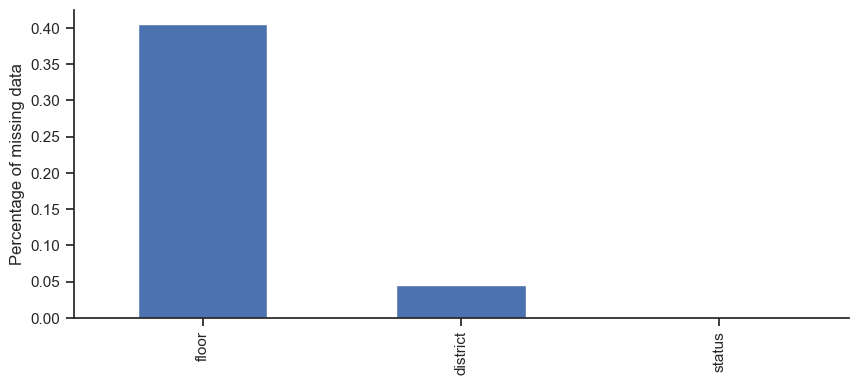

In [ ]:
# plot

data_train[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')

plt.show()

In [ ]:
# now we can determine which variables, from those with missing data,
# are numerical and which are categorical

cat_na = [var for var in cat_vars if var in vars_with_na]
num_na = [var for var in num_vars if var in vars_with_na]

print('Number of categorical variables with na: ', len(cat_na))
print('Number of numerical variables with na: ', len(num_na))

Number of categorical variables with na:  3
Number of numerical variables with na:  0


In [ ]:
num_na

[]

In [ ]:
cat_na

['floor', 'district', 'status']

In [ ]:
# variables to impute with the string missing
with_missing = [var for var in cat_na if data_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_mode = [var for var in cat_na if data_train[var].isnull().mean() < 0.1]

In [ ]:
with_missing, with_mode

(['floor'], ['district', 'status'])

# Categorical variables

Let's go ahead and analyse the categorical variables present in the dataset.

In [ ]:
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  13


In [ ]:
# let's visualise the values of the categorical variables
data_train[cat_vars].head()

floor propertyType       municipality  \
propertyCode                                         
33970699        10         flat             Lumiar   
33596240        bj         flat    Penha de França   
33930203        bj         flat     Avenidas Novas   
33847883         1         flat     Avenidas Novas   
33191605       NaN         flat  Santa Maria Maior   

                                                       district status  \
propertyCode                                                             
33970699      Alto do Lumiar - Quinta das Conchas - Quinta d...   good   
33596240                                                 Centro   good   
33930203                                          Campo Pequeno   good   
33847883                       Bairro Azul - Parque Eduardo VII   good   
33191605                                            Alfama - Sé   good   

                                nearestMallName nearestTrainName  \
propertyCode                                                       
33970699       Modelo Bonjour Galerias Lambert       Entrecampos   
33596240            Centro Comercial Portugália           Chelas   
33930203      Centro Comercial São João de Deus      Entrecampos   
33847883             Galerias Marquês de Pombal           Rossio   
33191605              Centro Comercial Mouraria   Santa Apolónia   

                             nearestFairName  \
propertyCode                                   
33970699       Feira de Artesanato Português   
33596240      Feira Temática Penha de França   
33930203       Feira de Artesanato Português   
33847883            Feira do Passeio Público   
33191605                      Feira da Ladra   

                                         nearestParkName  \
propertyCode                                               
33970699      Parque da Quinta das Conchas e dos Lilases   
33596240                        Miradouro do Monte Agudo   
33930203          Jardim Gomes de Amorim - Casa da Moeda   
33847883                Parque Eduardo VII de Inglaterra   
33191605            Jardim Augusto Gil / Jardim da Graça   

                   nearestMarketName    nearestMetroName  \
propertyCode                                               
33970699      Mercado Alvalade Norte  Quinta das Conchas   
33596240          Mercado de Arroios               Anjos   
33930203        Mercado Arco do Cego       Campo Pequeno   
33847883        Mercado Arco do Cego              Parque   
33191605          Mercado da Ribeira      Santa Apolónia   

                                           nearestViewpointName  \
propertyCode                                                      
33970699      Miradouro do Parque da Bela Vista\r\nMiradouro...   
33596240                               Miradouro do Monte Agudo   
33930203                        Miradouro do Parque Eduardo VII   
33847883                        Miradouro do Parque Eduardo VII   
33191605                             Miradouro de Santo Estêvão   

                                          nearestPlaygroundName  
propertyCode                                                     
33970699                       Parque Infantil do Parque Europa  
33596240             Parque Infantil da Avenida General Roçadas  
33930203                 Parque Infantil do Jardim Gomes Amorim  
33847883      Parque Infantil do Parque Eduardo VII de Ingla...  
33191605              Parque Infantil da Rua das Escolas Gerais

## Number of labels: cardinality

Let's evaluate how many different categories are present in each of the variables.

<Axes: >

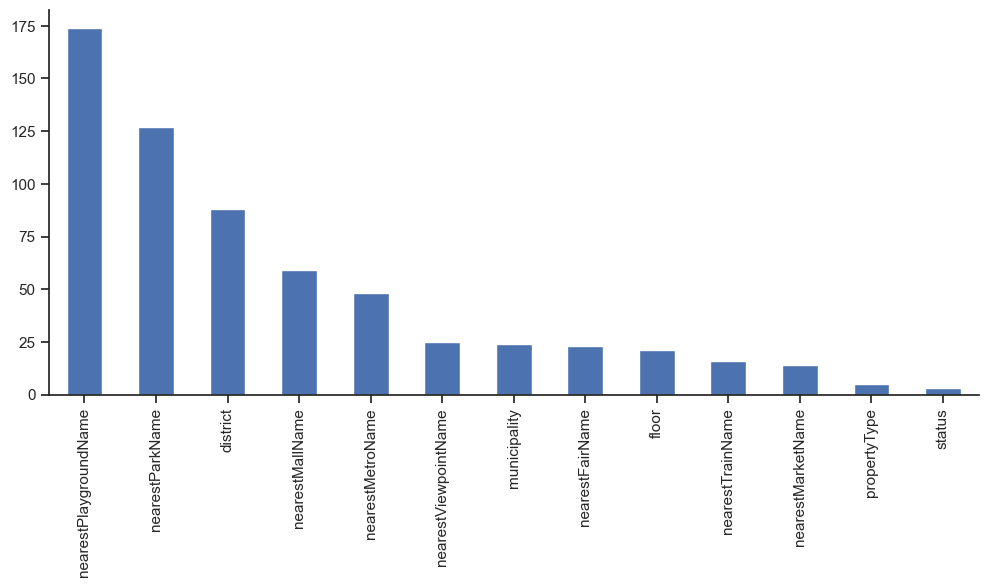

In [ ]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data_train[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

Some of the categorical variables show low cardinality, this means that they have only few different labels. However, some others have very high cardinality, which makes it clear we will have to deal with them somehow.

## Relationship between missing data and Sale Price

Let's evaluate the price of the house in those observations where the information is missing. We will do this for each variable that shows missing data_train.

In [ ]:
def analyse_na_value(df, var, target):

    # copy of the dataframe, so that we do not override the original data
    # see the link for more details about pandas.copy()
    # https://pandas.pydata_train.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
    df = df.copy()

    # let's make an interim variable that indicates 1 if the
    # observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where data is available

    # determine the median price in the groups 1 and 0,
    # and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)[target].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title=target, color='green')

    plt.show()

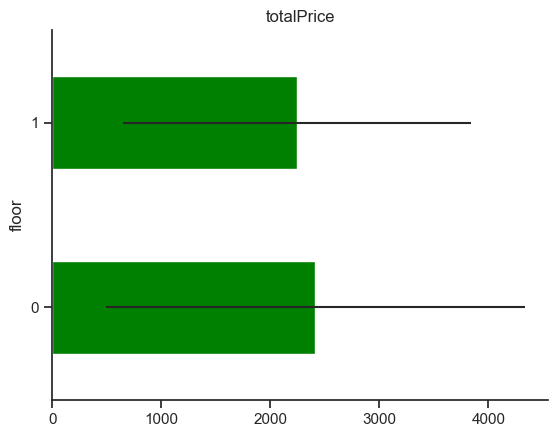

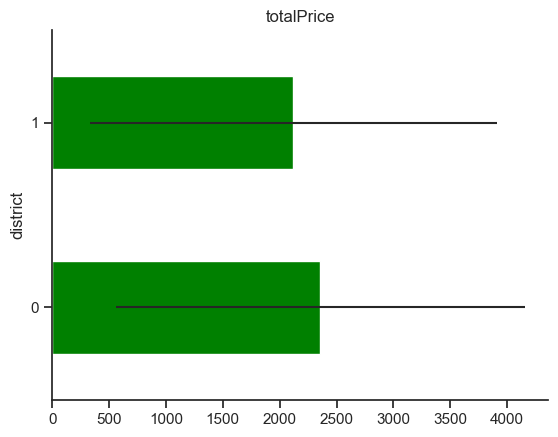

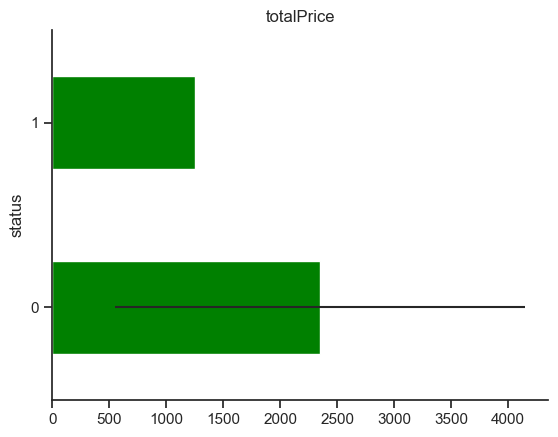

In [ ]:
# let's run the function on each variable with missing data

for var in vars_with_na:
    analyse_na_value(data_train, var, 'totalPrice')

In some variables, the average rent price in houses where the information is missing, differs from the average rent price in listings where this information exists. This suggests that data being missing could be a good predictor of rent price.

In [ ]:
from feature_engine.imputation import CategoricalImputer

ci = CategoricalImputer(imputation_method='frequent', variables=with_mode)
data_train = ci.fit_transform(data_train)

In [ ]:
from feature_engine.imputation import CategoricalImputer

ci = CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=with_missing)
data_train = ci.fit_transform(data_train)

## Rare labels:

Let's go ahead and investigate now if there are labels that are present only in a small number of houses:

In [ ]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)[target[0]].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data_train, var, 0.01))
    print()

floor
-2    0.000422
10    0.003797
11    0.002532
12    0.001688
13    0.002532
14    0.000844
15    0.001688
16    0.000422
17    0.000422
9     0.005907
en    0.001688
st    0.005907
Name: totalPrice, dtype: float64

propertyType
penthouse    0.005907
Name: totalPrice, dtype: float64

municipality
Beato          0.009283
Carnide        0.008861
Santa Clara    0.006751
Name: totalPrice, dtype: float64

district
Alto da Ajuda                             0.000422
Alto de Alcântara                         0.006329
Alto de Santo Amaro                       0.009705
Alto de São João - Alto do Varejão        0.006751
Alto dos Moinhos                          0.009283
Alvalade                                  0.009283
Alvito - Quinta do Jacinto                0.002110
Amoreiras                                 0.004219
Arco do Cego                              0.002532
Arneiros                                  0.005063
Av. de Roma - Campo Pequeno               0.005907
Avenida do Uruguai    

In [ ]:
from feature_engine.encoding import RareLabelEncoder

# let's group the categories that appear in less than 1% of the data
rle = RareLabelEncoder(n_categories=1, tol=0.01, variables=cat_vars)
data_train = rle.fit_transform(data_train)

<Axes: >

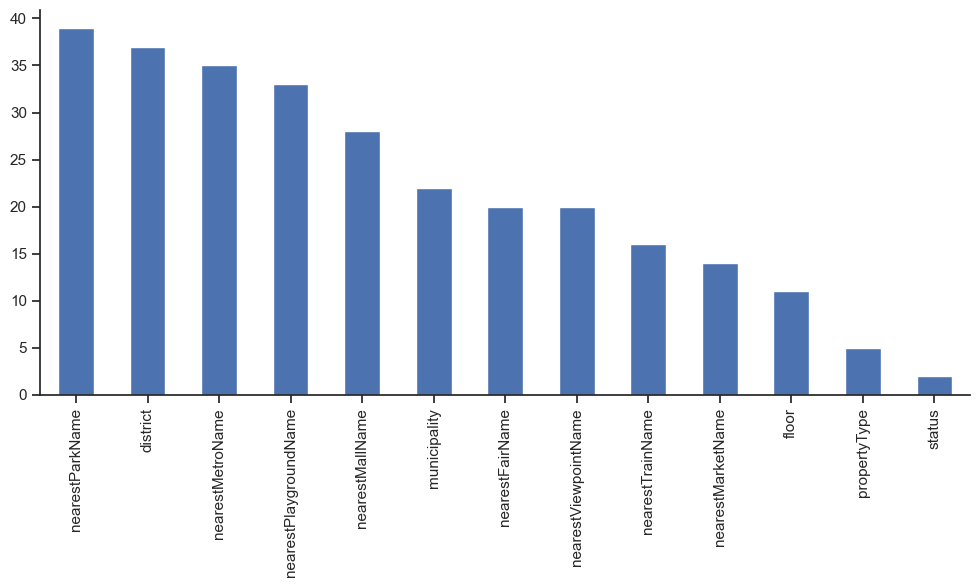

In [ ]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data_train[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [ ]:
cardinality = data_train[cat_vars].nunique().sort_values(ascending=False)

In [ ]:
one_hot_vars = cardinality[cardinality <= 5].index.tolist()
ordinal_vars = cardinality[cardinality > 5].index.tolist()

Some of the categorical variables show multiple labels that are present in less than 1% of the houses. 

Labels that are under-represented in the dataset tend to cause over-fitting of machine learning models. 

That is why we want to remove them.

Finally, we want to explore the relationship between the categories of the different variables and the house sale price:

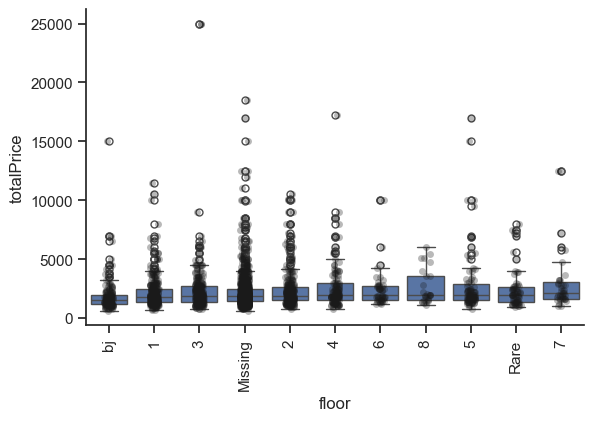

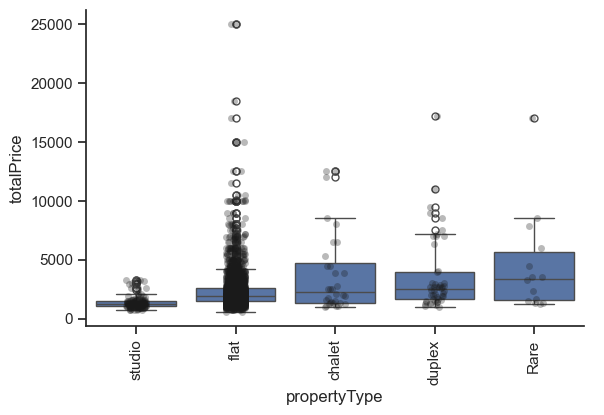

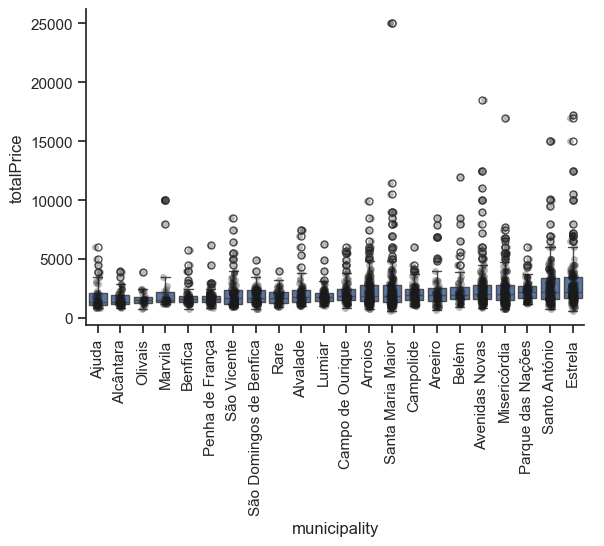

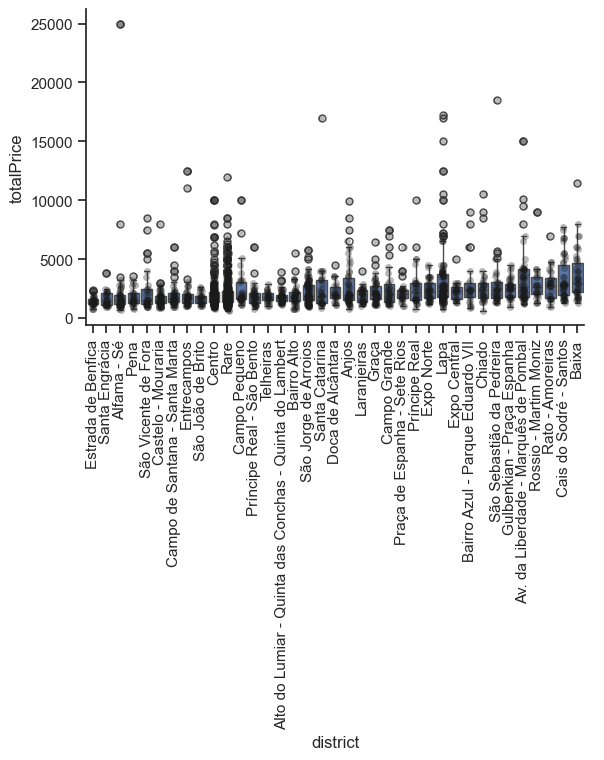

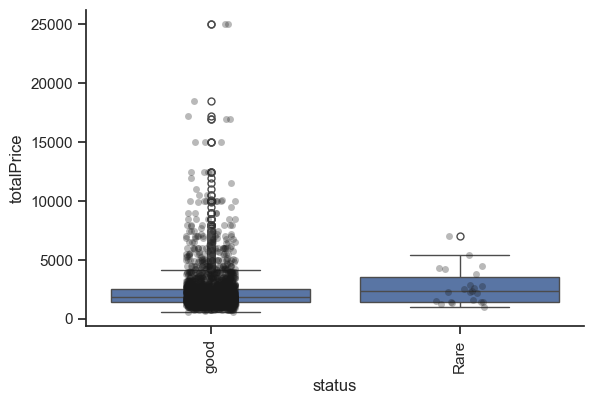

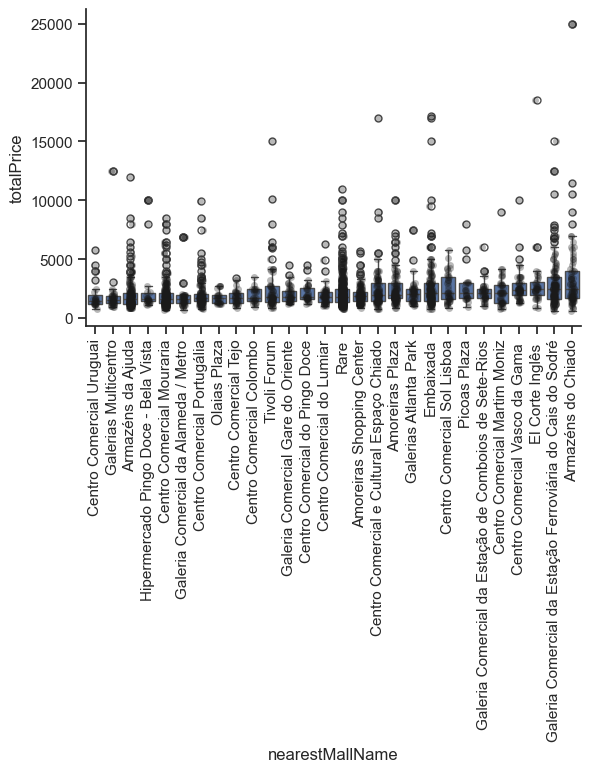

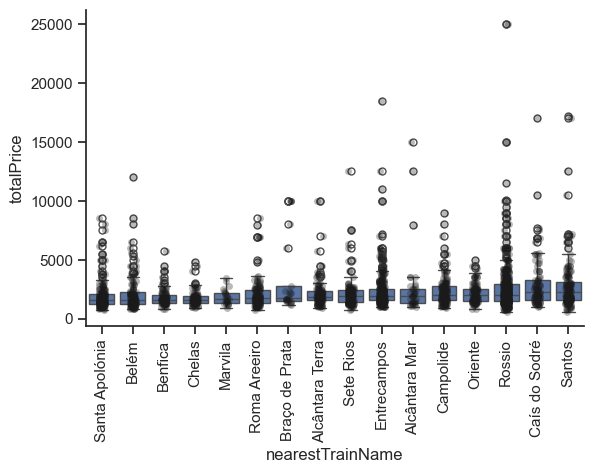

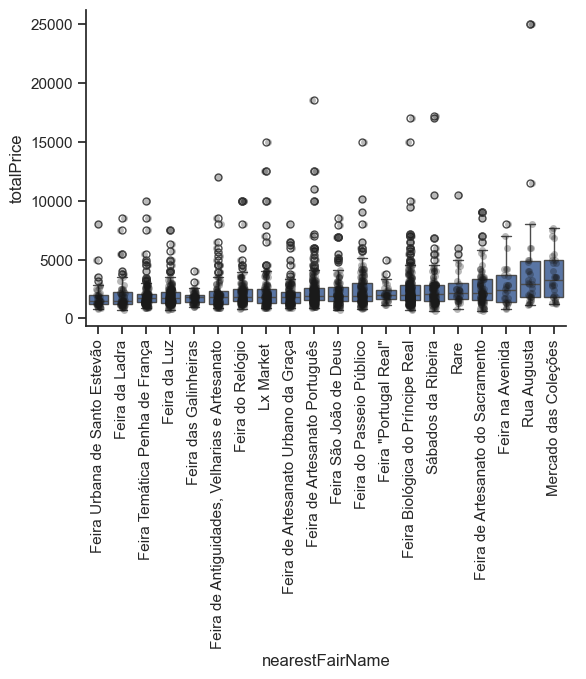

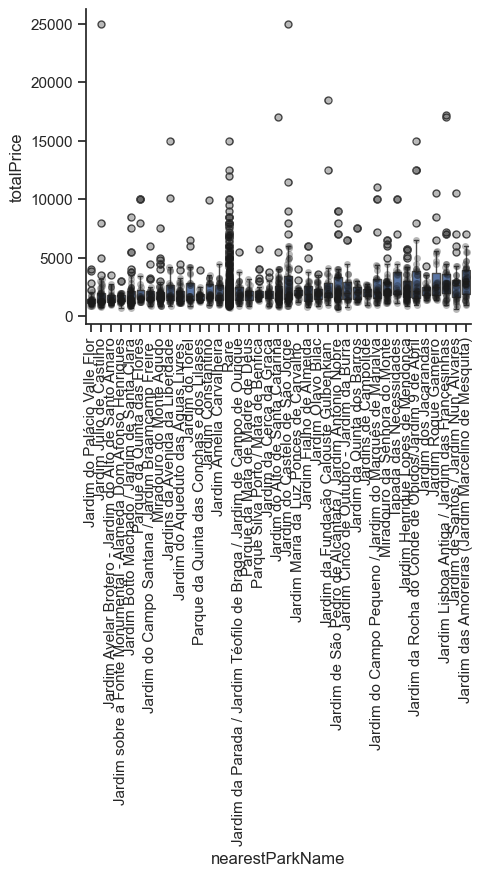

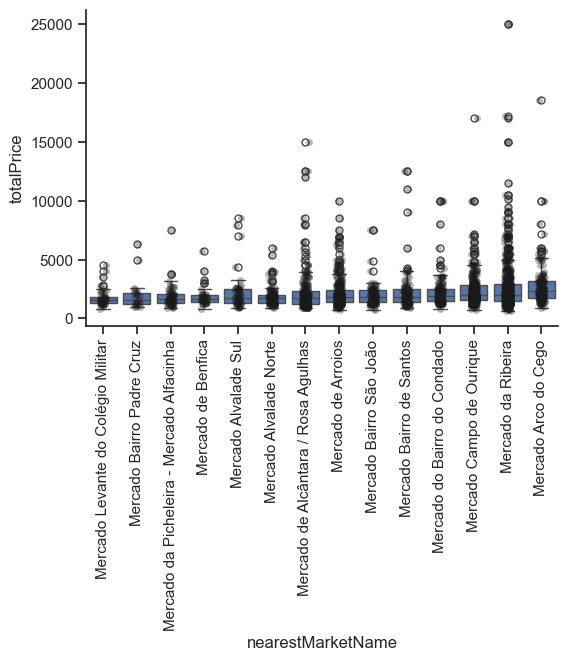

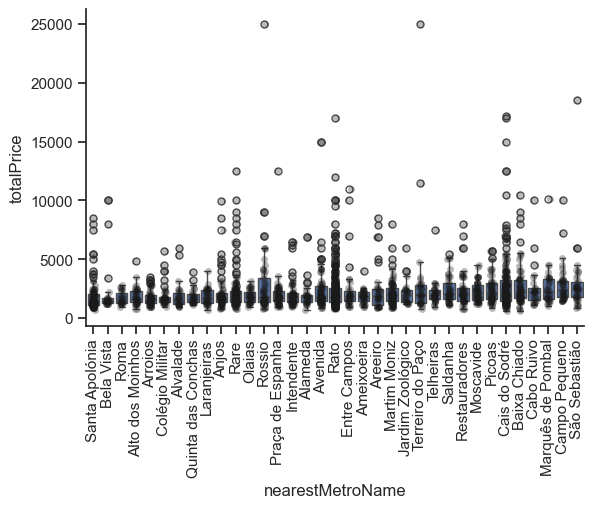

) missing from font(s) Arial.housing-prices/.conda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 13 (
  self._figure.tight_layout(*args, **kwargs)
) missing from font(s) Arial.housing-prices/.conda/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 13 (
  fig.canvas.draw()
) missing from font(s) Arial.housing-prices/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


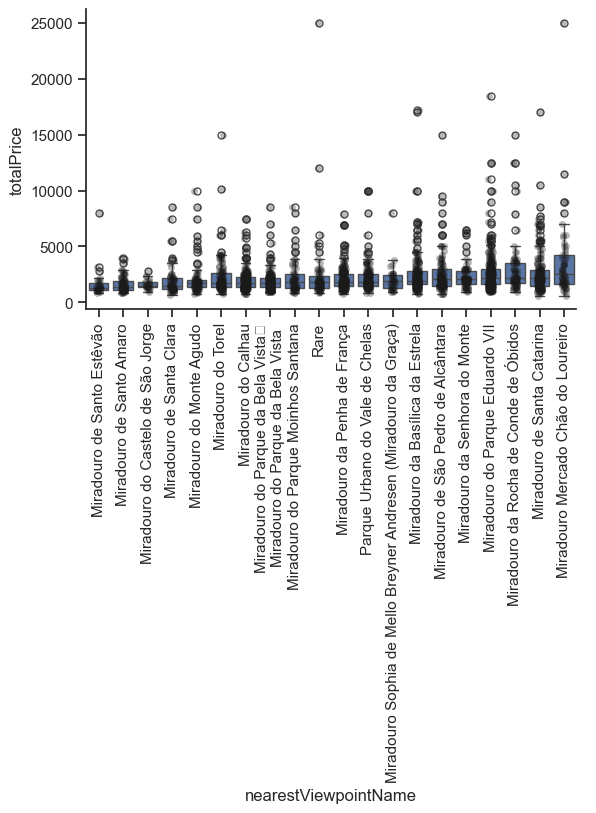

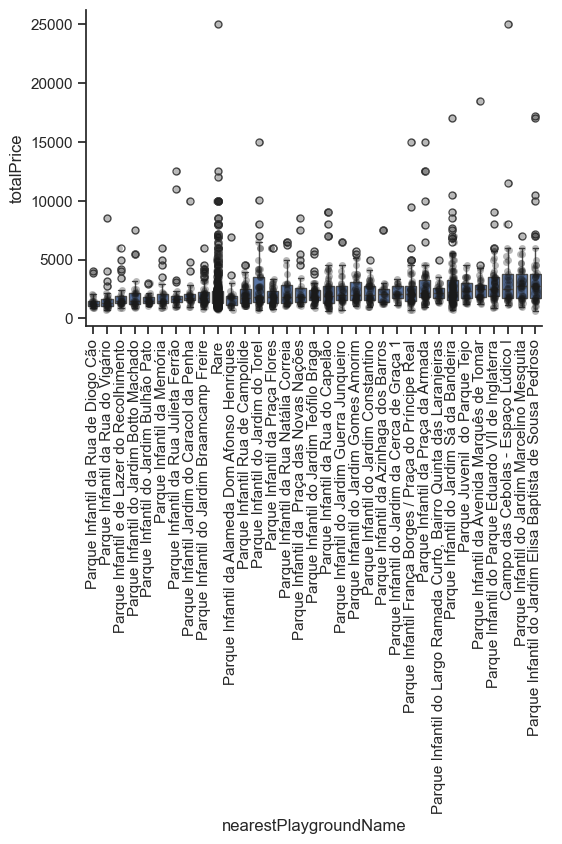

In [ ]:
for var in cat_vars:
    order_idx = data_train.groupby(var)[target[0]].median().sort_values().index
    # make boxplot with Catplot
    sns.catplot(
        x=var, y=target[0], data=data_train, kind="box", height=4, aspect=1.5, order=order_idx
    )
    # add data points to boxplot with stripplot
    strip_plot = sns.stripplot(
        x=var, y=target[0], data=data_train, jitter=0.1, alpha=0.3, color="k", order=order_idx
    )
    # Set proper tick locations before changing labels
    strip_plot.set_xticks(range(len(data_train[var].unique())))
    strip_plot.set_xticklabels(strip_plot.get_xticklabels(), rotation=90)

    plt.show()

In [ ]:
data_train.shape

(2370, 41)

In [ ]:
len(features)

40

Clearly, the categories give information on the SalePrice, as different categories show different median sale prices.

In [ ]:
from feature_engine.encoding import OrdinalEncoder

# set up the encoder
oe = OrdinalEncoder(encoding_method='ordered', variables=ordinal_vars)

# create the mappings
oe.fit(data_train[features], data_train[target].squeeze())
data_train[features] = oe.transform(data_train[features])

# mappings are stored and class can be saved
oe.encoder_dict_

{'nearestParkName': {'Jardim do Palácio Valle Flor': 0,
  'Jardim sobre a Fonte Monumental - Alameda Dom Afonso Henriques': 1,
  'Jardim Avelar Brotero - Jardim do Alto de Santo Amaro': 2,
  'Parque da Quinta das Conchas e dos Lilases': 3,
  'Parque da Mata de Madre de Deus': 4,
  'Jardim do Aqueduto das Águas Livres ': 5,
  'Jardim da Cerca da Graça': 6,
  'Jardim Botto Machado / Jardim de Santa Clara': 7,
  'Jardim do Campo Santana / Jardim Braamcamp Freire ': 8,
  'Miradouro do Monte Agudo': 9,
  'Jardim da Parada / Jardim Téofilo de Braga / Jardim de Campo de Ourique': 10,
  'Jardim Olavo Bilac': 11,
  'Jardim Maria da Luz Ponces de Carvalho ': 12,
  'Jardim Amélia Carvalheira': 13,
  'Jardins de Campolide': 14,
  'Parque Silva Porto / Mata de Benfica': 15,
  'Jardim Constantino': 16,
  'Jardim Fialho de Almeida': 17,
  'Jardim Júlio de Castilho': 18,
  'Rare': 19,
  'Jardim do Alto de Santa Catarina': 20,
  'Jardim dos Jacarandás': 21,
  'Jardim da Quinta dos Barros': 22,
  'Jardi

In [ ]:
data_train.shape

(2370, 41)

In [ ]:
from feature_engine.encoding import OneHotEncoder

# set up the encoder
ohe = OneHotEncoder(drop_last=True, variables=one_hot_vars)

ohe.fit(data_train[features])
new_features = ohe.get_feature_names_out()
data_train[new_features] = ohe.transform(data_train[features])
data_train = data_train.drop(columns=one_hot_vars)
features = new_features

In [ ]:
data_train

floor   size  rooms  bathrooms  municipality  district  \
propertyCode                                                           
33970699          5  132.0      3          2             7         6   
33596240          0   55.0      1          1             2        12   
33930203          0  220.0      8          3            18        24   
33847883          1   92.0      2          2            18        29   
33191605          2   45.0      1          1            17        21   
...             ...    ...    ...        ...           ...       ...   
33975357          3   73.0      2          1             5        11   
33890243          2   74.0      2          2            12        27   
33921312          2   11.0      1          1            15        11   
33929934          4  182.0      4          3             7        11   
33831842          4   81.0      2          2            17        32   

               latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                                
33970699      38.766250  -9.153749        False     False           False   
33596240      38.727992  -9.130264        False      True           False   
33930203      38.739631  -9.144151        False     False           False   
33847883      38.727179  -9.148304        False     False           False   
33191605      38.714311  -9.127903        False     False           False   
...                 ...        ...          ...       ...             ...   
33975357      38.753561  -9.198147        False     False           False   
33890243      38.727753  -9.131819         True     False           False   
33921312      38.709420  -9.144905        False     False           False   
33929934      38.775930  -9.171521        False     False           False   
33831842      38.714966  -9.141242         True     False           False   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33970699        False     True      False   False       False   
33596240        False    False      False   False       False   
33930203         True    False      False   False       False   
33847883         True     True       True   False       False   
33191605        False    False      False   False       False   
...               ...      ...        ...     ...         ...   
33975357         True    False      False   False       False   
33890243        False    False      False   False       False   
33921312        False    False      False   False       False   
33929934        False    False      False   False       False   
33831842         True    False      False   False       False   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33970699                  False    False                   False   
33596240                  False    False                   False   
33930203                  False    False                   False   
33847883                  False    False                   False   
33191605                  False    False                   False   
...                         ...      ...                     ...   
33975357                  False    False                   False   
33890243                  False    False                   False   
33921312                  False    False                   False   
33929934                  False    False                   False   
33831842                  False    False                   False   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33970699               False             True                           True   
33596240               False            False                          False   
33930203               F

# Numerical variables

Let's go ahead and find out what numerical variables we have in the dataset

In [ ]:
print('Number of numerical variables: ', len(num_vars))

# visualise the numerical variables
data_train[num_vars].head()

Number of numerical variables:  13


size  rooms  bathrooms   latitude  longitude  \
propertyCode                                                  
33970699      132.0      3          2  38.766250  -9.153749   
33596240       55.0      1          1  38.727992  -9.130264   
33930203      220.0      8          3  38.739631  -9.144151   
33847883       92.0      2          2  38.727179  -9.148304   
33191605       45.0      1          1  38.714311  -9.127903   

              distanceToNearestMall  distanceToNearestTrain  \
propertyCode                                                  
33970699                 402.994549             3164.229600   
33596240                 596.319483             2021.221789   
33930203                 405.163272              864.932068   
33847883                 204.792268             1918.577448   
33191605                 888.899543              688.228568   

              distanceToNearestFair  distanceToNearestPark  \
propertyCode                                                 
33970699                3397.618311             607.948626   
33596240                 504.187198             339.362951   
33930203                 550.332912             280.244029   
33847883                1180.649079             548.883216   
33191605                 241.140890             426.796200   

              distanceToNearestMarket  distanceToNearestMetro  \
propertyCode                                                    
33970699                  2105.665995              267.783033   
33596240                  1045.089695              518.766962   
33930203                   284.183464              337.450253   
33847883                  1976.620402              324.627792   
33191605                  2259.143223              622.427815   

              distanceToNearestViewpoint  distanceToNearestPlayground  
propertyCode                                                           
33970699                     3229.915335                    56.412310  
33596240                      298.808010                   254.702235  
33930203                     1753.120284                   276.762513  
33847883                      823.661486                   674.791137  
33191605                      320.225561                   209.483372

## Discrete variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [ ]:
#  let's male a list of discrete variables
discrete_vars = [var for var in num_vars if len(data_train[var].unique()) < 20]


print("Number of discrete variables: ", len(discrete_vars))

Number of discrete variables:  2


In [ ]:
# let's visualise the discrete variables

data_train[discrete_vars].head()

rooms  bathrooms
propertyCode                  
33970699          3          2
33596240          1          1
33930203          8          3
33847883          2          2
33191605          1          1

These discrete variables refer to the number of rooms and bathrooms.

We expect higher prices, with bigger numbers.

Let's go ahead and analyse their contribution to the listing price.

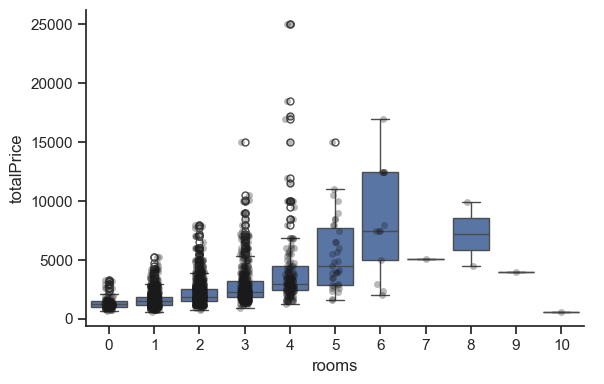

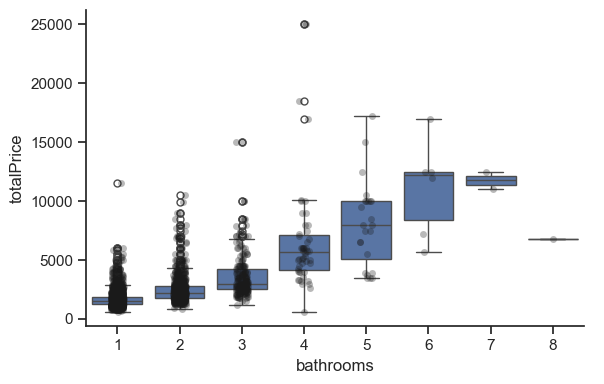

In [ ]:
for var in discrete_vars:
    # make boxplot with Catplot
    sns.catplot(x=var, y=target[0], data=data_train, kind="box", height=4, aspect=1.5)
    # add data points to boxplot with stripplot
    sns.stripplot(x=var, y=target[0], data=data_train, jitter=0.1, alpha=0.3, color='k')
    plt.show()

Clearly, the price does increase with increasing number of rooms and bathrooms. There seem to be few outliers in both variables, so we'll have to deal with those in a bit.

## Continuous variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not temporal or discrete.

In [ ]:
# make list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars]

print("Number of continuous variables: ", len(cont_vars))

Number of continuous variables:  11


In [ ]:
# let's visualise the continuous variables

data_train[cont_vars].head()

size   latitude  longitude  distanceToNearestMall  \
propertyCode                                                       
33970699      132.0  38.766250  -9.153749             402.994549   
33596240       55.0  38.727992  -9.130264             596.319483   
33930203      220.0  38.739631  -9.144151             405.163272   
33847883       92.0  38.727179  -9.148304             204.792268   
33191605       45.0  38.714311  -9.127903             888.899543   

              distanceToNearestTrain  distanceToNearestFair  \
propertyCode                                                  
33970699                 3164.229600            3397.618311   
33596240                 2021.221789             504.187198   
33930203                  864.932068             550.332912   
33847883                 1918.577448            1180.649079   
33191605                  688.228568             241.140890   

              distanceToNearestPark  distanceToNearestMarket  \
propertyCode                                                   
33970699                 607.948626              2105.665995   
33596240                 339.362951              1045.089695   
33930203                 280.244029               284.183464   
33847883                 548.883216              1976.620402   
33191605                 426.796200              2259.143223   

              distanceToNearestMetro  distanceToNearestViewpoint  \
propertyCode                                                       
33970699                  267.783033                 3229.915335   
33596240                  518.766962                  298.808010   
33930203                  337.450253                 1753.120284   
33847883                  324.627792                  823.661486   
33191605                  622.427815                  320.225561   

              distanceToNearestPlayground  
propertyCode                               
33970699                        56.412310  
33596240                       254.702235  
33930203                       276.762513  
33847883                       674.791137  
33191605                       209.483372

In [ ]:
data_train[cont_vars].describe()

size     latitude    longitude  distanceToNearestMall  \
count   2370.000000  2370.000000  2370.000000            2370.000000   
mean     126.141350    38.728877    -9.150023             761.305520   
std     1652.947235     0.020510     0.024447             598.049717   
min       11.000000    38.693598    -9.226113               1.846369   
25%       53.000000    38.712618    -9.163879             323.436077   
50%       78.000000    38.723786    -9.147835             577.673544   
75%      120.000000    38.742153    -9.134121            1011.932537   
max    80500.000000    38.793670    -9.091136            3686.974267   

       distanceToNearestTrain  distanceToNearestFair  distanceToNearestPark  \
count             2370.000000            2370.000000            2370.000000   
mean              1270.805384            1234.986156             404.980905   
std                887.317289             884.307676             224.570393   
min                 33.336798               7.834411               1.815796   
25%                688.061784             520.344443             241.567555   
50%               1064.579365            1025.612195             375.950479   
75%               1624.458974            1761.649156             533.102700   
max               6424.650017            5509.990808            1557.284856   

       distanceToNearestMarket  distanceToNearestMetro  \
count              2370.000000             2370.000000   
mean               1487.375660             1080.593381   
std                1034.808971             1366.153968   
min                  21.926069               11.315896   
25%                 770.991008              377.916799   
50%                1291.992444              621.482101   
75%                1903.680616             1098.444697   
max                7132.436102             8146.904727   

       distanceToNearestViewpoint  distanceToNearestPlayground  
count                 2370.000000                  2370.000000  
mean                  1251.920546                   397.427424  
std                   1159.023461                   230.376203  
min                      6.535194                     6.428992  
25%                    447.608265                   220.294653  
50%                    856.944192                   365.601219  
75%                   1558.037196                   532.699426  
max                   6164.385765                  1856.025882

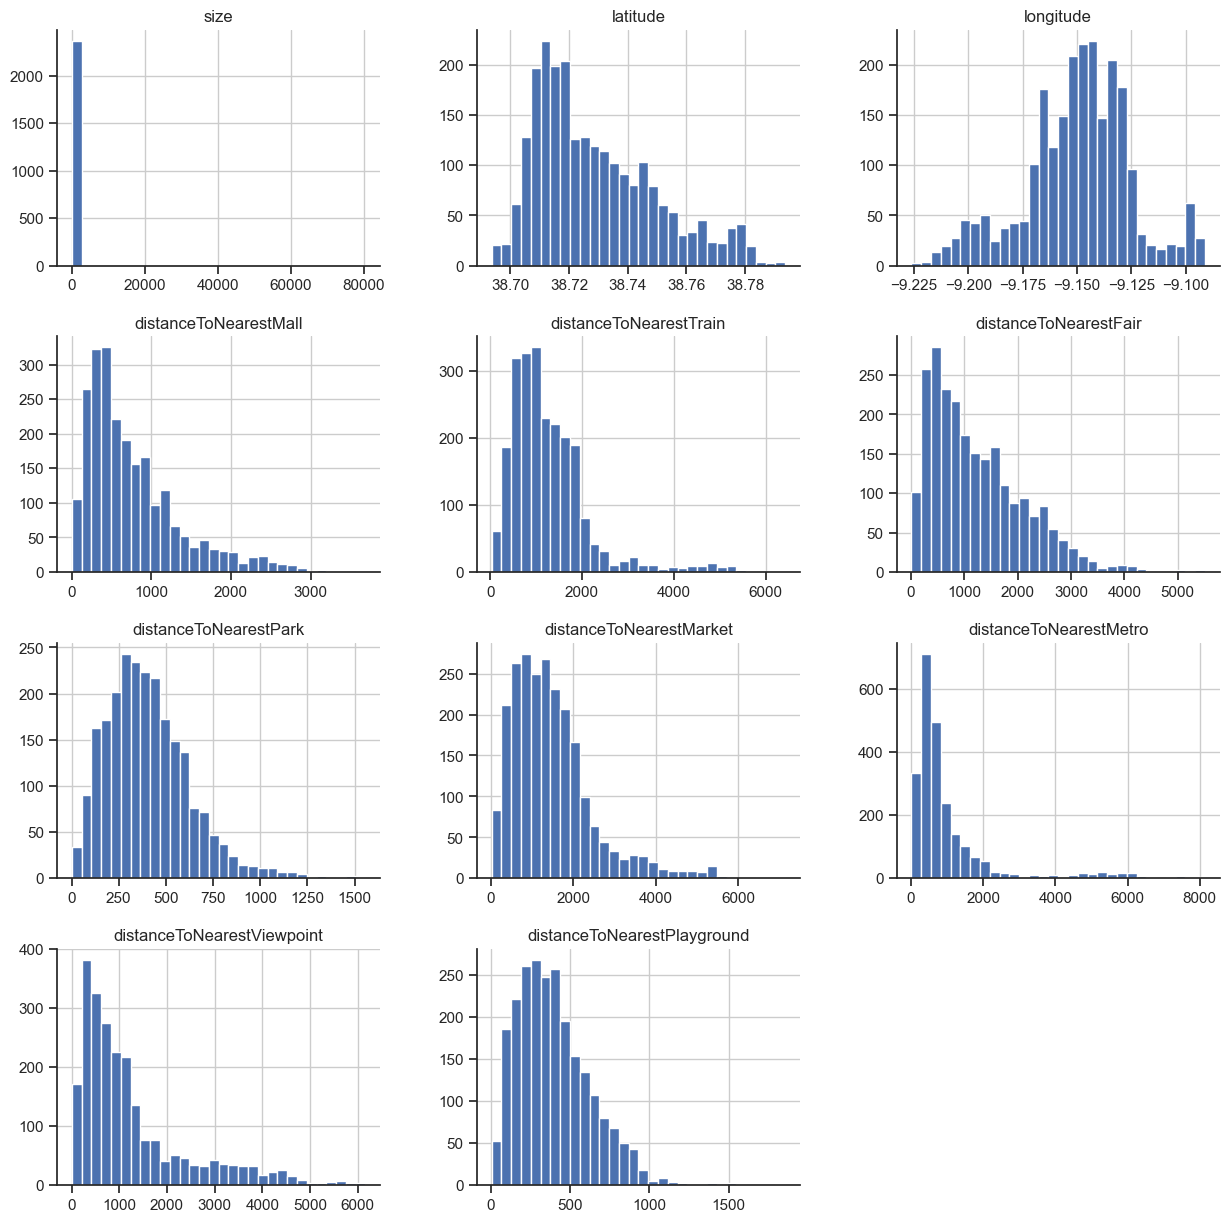

In [ ]:
# lets plot histograms for all continuous variables

data_train[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

The variables are not normally distributed, and most of them are left skewed.

Sometimes, transforming the variables to improve the value spread, improves the model performance. But it is unlikely that a transformation will help change the distribution of the super skewed variables dramatically.

We can apply a Yeo-Johnson transformation, let's go ahead and do that.

In [ ]:
# Identify columns with non-finite values
for var in cont_vars:
    if not np.all(np.isfinite(data_train[var])):
        print(f"Non-finite values found in column: {var}")

### Yeo-Johnson transformation

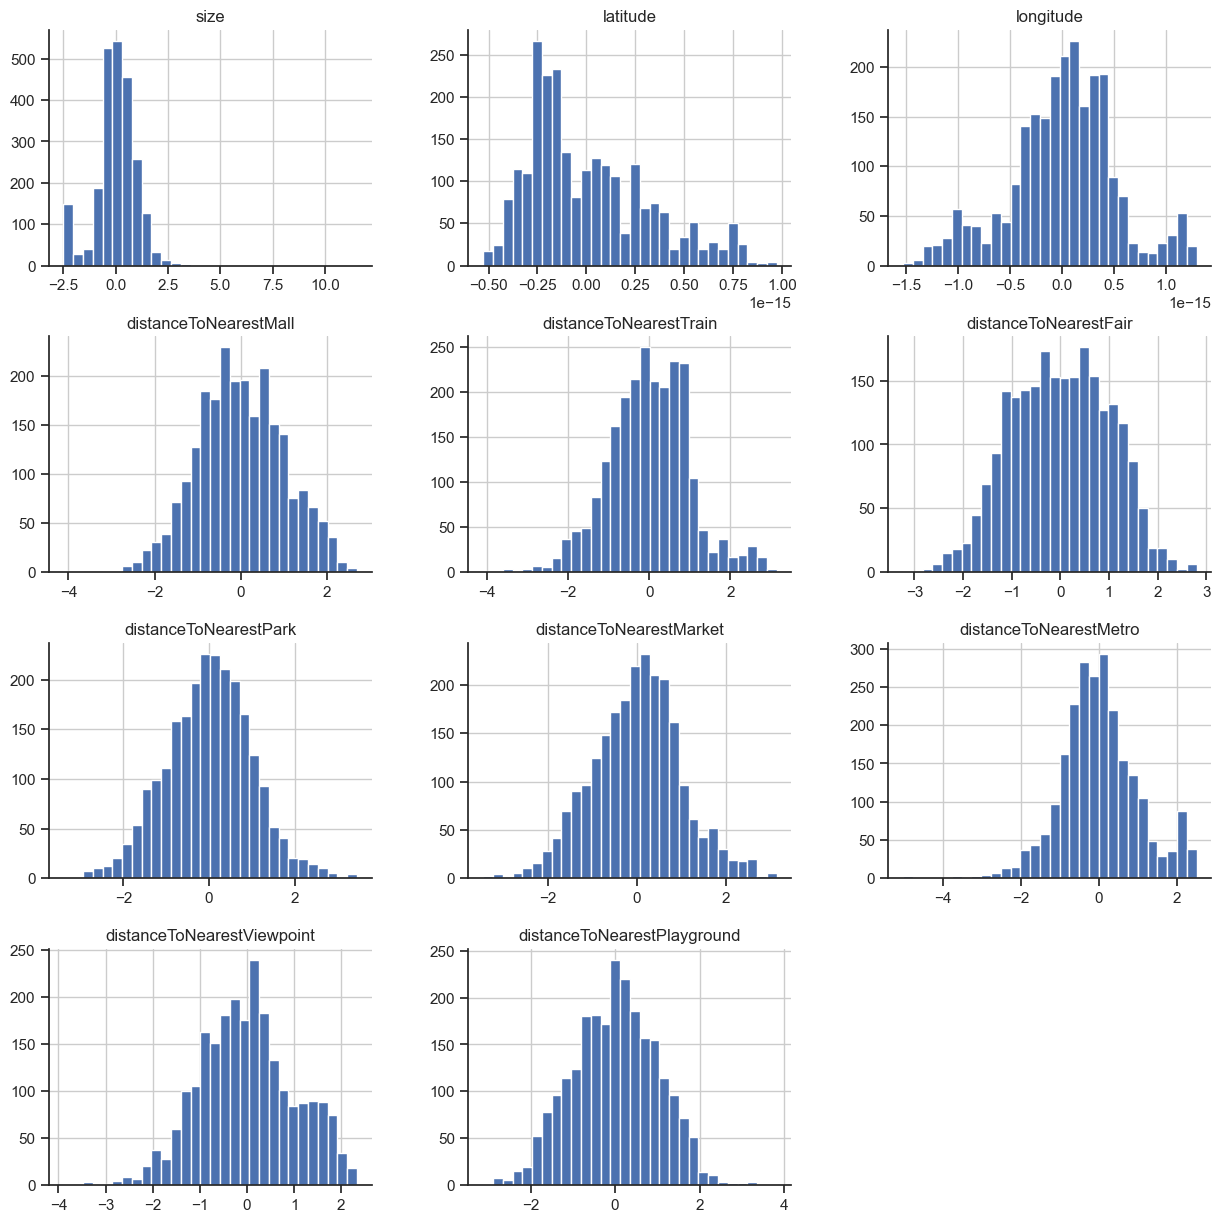

In [ ]:
# Let's go ahead and analyse the distributions of the variables
# after applying a yeo-johnson transformation

# temporary copy of the data
tmp = data_train.copy()

for var in cont_vars + ["totalPrice"]:
    # Apply PowerTransformer
    pt = PowerTransformer()
    tmp[var] = pt.fit_transform(data_train[var].values.reshape(-1,1))

    
# plot the histograms of the transformed variables
tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

For latitude and longitude, the transformation didn't do anything useful, as the values are too small.

For the others, the values seem to be spread more evenly in the range and more normally distributed. Whether this helps improve the predictive power, remains to be seen. To determine if this is the case, we should train a model with the original values and one with the transformed values, and determine model performance, and feature importance.

In [ ]:
yeo_johnson_vars = [var for var in cont_vars if var == 'size' or 'distance' in var]

In [ ]:
yeo_johnson_vars

['size',
 'distanceToNearestMall',
 'distanceToNearestTrain',
 'distanceToNearestFair',
 'distanceToNearestPark',
 'distanceToNearestMarket',
 'distanceToNearestMetro',
 'distanceToNearestViewpoint',
 'distanceToNearestPlayground']

# Outliers

We're interested in removing the outliers for a few key features: size, rooms, and bathrooms. Additionally, we recognized that there are few re-ocurring values in the size feature that are likely data entry errors and/or data inconsistencies.

We have different strategies for each of them, so we'll tackle those in a bit. First, we'll tacke the overly frequent values in the size feature.

In [ ]:
# Identify overly frequent values dynamically
def flag_frequent_values(df, column, threshold=0.05):
    """
    Identifies values in a column that appear with a frequency higher than `threshold` (default: 5% of the data).
    Returns a list of those values.
    """
    value_counts = df[column].value_counts(normalize=True)
    frequent_values = value_counts[value_counts > threshold].index.tolist()
    return frequent_values

In [ ]:
from sklearn.impute import KNNImputer, MissingIndicator

# Find overly common values in the 'size' column
frequent_sizes = flag_frequent_values(data_train, 'size', threshold=0.05)

# Replace overly common values with NaN
data_train.loc[data_train['size'].isin(frequent_sizes), 'size'] = np.nan

# Apply Missing Indicator
missing_indicator = MissingIndicator()
missing_indicator.fit(data_train[features])
new_features = missing_indicator.get_feature_names_out().tolist()
data_train[new_features] = missing_indicator.transform(data_train[features])
features.extend(new_features)

In [ ]:
data_train

floor   size  rooms  bathrooms  municipality  district  \
propertyCode                                                           
33970699          5  132.0      3          2             7         6   
33596240          0   55.0      1          1             2        12   
33930203          0  220.0      8          3            18        24   
33847883          1   92.0      2          2            18        29   
33191605          2   45.0      1          1            17        21   
...             ...    ...    ...        ...           ...       ...   
33975357          3   73.0      2          1             5        11   
33890243          2   74.0      2          2            12        27   
33921312          2    NaN      1          1            15        11   
33929934          4  182.0      4          3             7        11   
33831842          4   81.0      2          2            17        32   

               latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                                
33970699      38.766250  -9.153749        False     False           False   
33596240      38.727992  -9.130264        False      True           False   
33930203      38.739631  -9.144151        False     False           False   
33847883      38.727179  -9.148304        False     False           False   
33191605      38.714311  -9.127903        False     False           False   
...                 ...        ...          ...       ...             ...   
33975357      38.753561  -9.198147        False     False           False   
33890243      38.727753  -9.131819         True     False           False   
33921312      38.709420  -9.144905        False     False           False   
33929934      38.775930  -9.171521        False     False           False   
33831842      38.714966  -9.141242         True     False           False   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33970699        False     True      False   False       False   
33596240        False    False      False   False       False   
33930203         True    False      False   False       False   
33847883         True     True       True   False       False   
33191605        False    False      False   False       False   
...               ...      ...        ...     ...         ...   
33975357         True    False      False   False       False   
33890243        False    False      False   False       False   
33921312        False    False      False   False       False   
33929934        False    False      False   False       False   
33831842         True    False      False   False       False   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33970699                  False    False                   False   
33596240                  False    False                   False   
33930203                  False    False                   False   
33847883                  False    False                   False   
33191605                  False    False                   False   
...                         ...      ...                     ...   
33975357                  False    False                   False   
33890243                  False    False                   False   
33921312                  False    False                   False   
33929934                  False    False                   False   
33831842                  False    False                   False   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33970699               False             True                           True   
33596240               False            False                          False   
33930203               F

In [ ]:
len(features)

44

In [ ]:
# Apply KNN Imputer
size_imputer = KNNImputer(n_neighbors=5, weights='distance')
size_imputer.fit(data_train[num_vars])
new_features = size_imputer.get_feature_names_out().tolist()
data_train[new_features] = size_imputer.transform(data_train[num_vars])

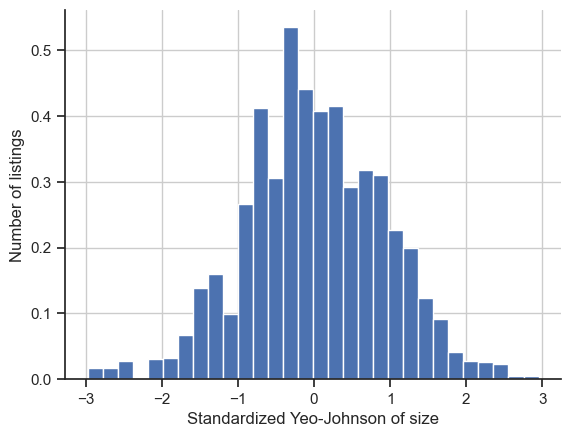

In [ ]:
# Transform with the Yeo-Johnson transformation
pt_features = PowerTransformer()
data_train[yeo_johnson_vars] = pt_features.fit_transform(data_train[yeo_johnson_vars])

pt_target = PowerTransformer()
data_train[target] = pt_target.fit_transform(data_train[target])

# Filter out extreme values
data_train = data_train[abs(data_train['size']) <= 3]
data_train = data_train[abs(data_train[target[0]]) <= 3]

# Plot
data_train['size'].hist(bins=30, density=True)
plt.ylabel('Number of listings')
plt.xlabel('Standardized Yeo-Johnson of size')
plt.show()

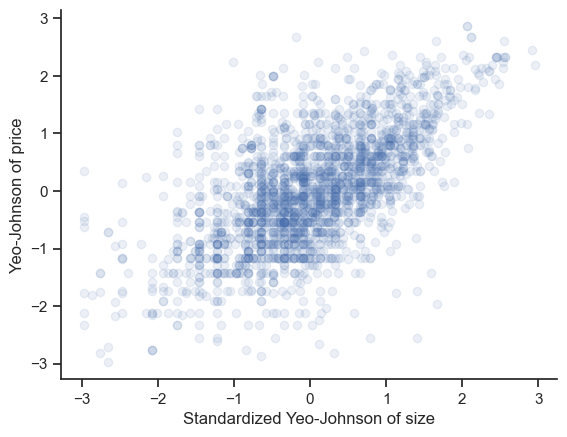

In [ ]:
# Plot
plt.scatter(x='size', y='totalPrice', data=data_train, alpha=0.1)
plt.ylabel('Yeo-Johnson of price')
plt.xlabel('Standardized Yeo-Johnson of size')
plt.show()

In [ ]:
data_train

floor      size  rooms  bathrooms  municipality  district  \
propertyCode                                                              
33970699          5  0.822845    3.0        2.0             7         6   
33596240          0 -0.815292    1.0        1.0             2        12   
33930203          0  1.682521    8.0        3.0            18        24   
33847883          1  0.173151    2.0        2.0            18        29   
33191605          2 -1.221090    1.0        1.0            17        21   
...             ...       ...    ...        ...           ...       ...   
33975357          3 -0.262104    2.0        1.0             5        11   
33890243          2 -0.236090    2.0        2.0            12        27   
33921312          2 -0.006595    1.0        1.0            15        11   
33929934          4  1.371368    4.0        3.0             7        11   
33831842          4 -0.064592    2.0        2.0            17        32   

               latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                                
33970699      38.766250  -9.153749        False     False           False   
33596240      38.727992  -9.130264        False      True           False   
33930203      38.739631  -9.144151        False     False           False   
33847883      38.727179  -9.148304        False     False           False   
33191605      38.714311  -9.127903        False     False           False   
...                 ...        ...          ...       ...             ...   
33975357      38.753561  -9.198147        False     False           False   
33890243      38.727753  -9.131819         True     False           False   
33921312      38.709420  -9.144905        False     False           False   
33929934      38.775930  -9.171521        False     False           False   
33831842      38.714966  -9.141242         True     False           False   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33970699        False     True      False   False       False   
33596240        False    False      False   False       False   
33930203         True    False      False   False       False   
33847883         True     True       True   False       False   
33191605        False    False      False   False       False   
...               ...      ...        ...     ...         ...   
33975357         True    False      False   False       False   
33890243        False    False      False   False       False   
33921312        False    False      False   False       False   
33929934        False    False      False   False       False   
33831842         True    False      False   False       False   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33970699                  False    False                   False   
33596240                  False    False                   False   
33930203                  False    False                   False   
33847883                  False    False                   False   
33191605                  False    False                   False   
...                         ...      ...                     ...   
33975357                  False    False                   False   
33890243                  False    False                   False   
33921312                  False    False                   False   
33929934                  False    False                   False   
33831842                  False    False                   False   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33970699               False             True                           True   
33596240               False            False                    

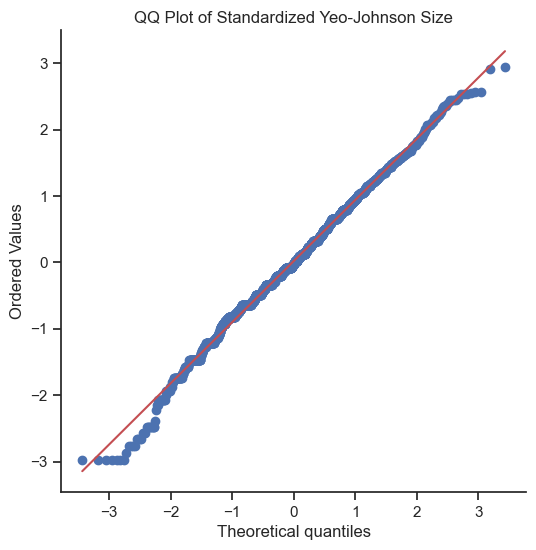

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
stats.probplot(data_train["size"], dist="norm", plot=ax)
ax.set_title("QQ Plot of Standardized Yeo-Johnson Size")
plt.show()

In [ ]:
data_train['size'].describe()

count    2339.000000
mean        0.018269
std         0.921578
min        -2.974042
25%        -0.610363
50%        -0.018703
75%         0.654778
max         2.949498
Name: size, dtype: float64

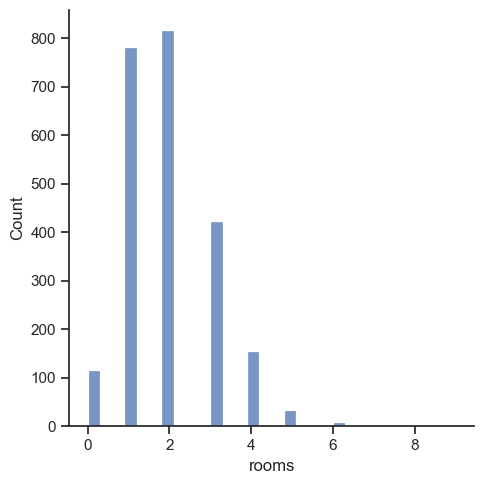

In [ ]:
sns.displot(data_train, x='rooms', kind='hist', bins=30)
plt.show()


In [ ]:
data_train['rooms'].describe()

count    2339.000000
mean        1.950406
std         1.107994
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: rooms, dtype: float64

In [ ]:
def remove_outliers_iqr(df, column, threshold=1.5):
    """
    Removes outliers from a DataFrame column using the IQR method.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to check for outliers.
        threshold (float, optional): The IQR multiplier (default is 1.5).

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df_filtered = df.copy()

    df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    
    return df_filtered

In [ ]:
data_train = remove_outliers_iqr(data_train, 'rooms')

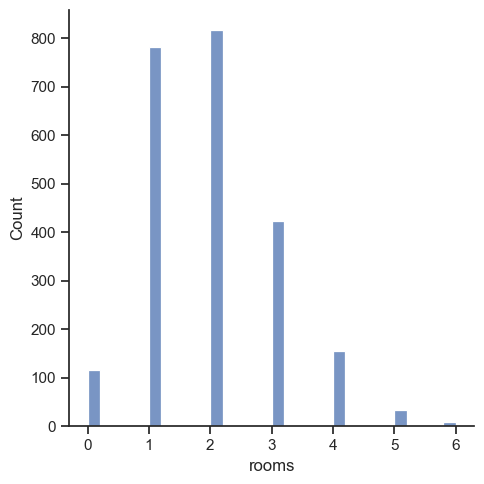

In [ ]:
sns.displot(data_train, x='rooms', kind='hist', bins=30)
plt.show()

In [ ]:
data_train['rooms'].describe()

count    2335.000000
mean        1.940043
std         1.079847
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

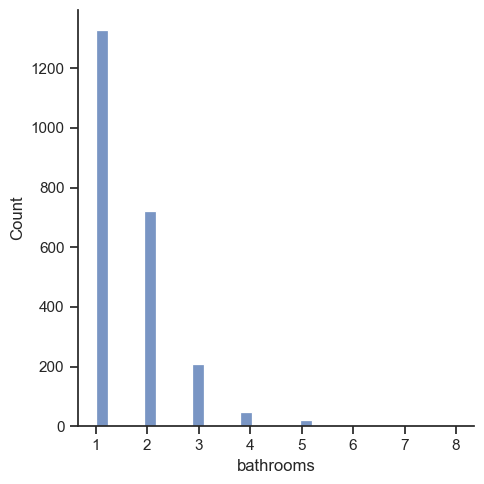

In [ ]:
sns.displot(data_train, x='bathrooms', kind='hist', bins=30)
plt.show()

In [ ]:
data_train['bathrooms'].describe()

count    2335.000000
mean        1.598715
std         0.841052
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: bathrooms, dtype: float64

In [ ]:
# Count occurrences of each value
value_counts = data_train['bathrooms'].value_counts(normalize=True)

# Define a threshold (e.g., values appearing in less than 1% of listings are outliers)
threshold = 0.01
outlier_values = value_counts[value_counts < threshold].index

# Remove or flag outliers
data_train = data_train[~data_train['bathrooms'].isin(outlier_values)]

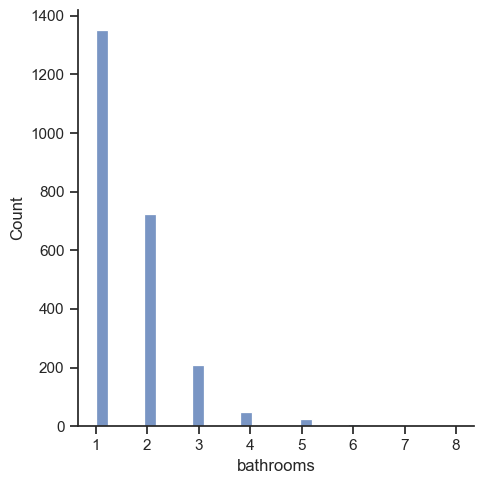

In [ ]:
sns.displot(tmp, x='bathrooms', kind='hist', bins=30)
plt.show()

In [ ]:
data_train['bathrooms'].describe()

count    2308.000000
mean        1.555893
std         0.743062
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: bathrooms, dtype: float64

# Data Preparation

In [ ]:
boolean_vars = data_train.select_dtypes(include='bool').columns.tolist()
binary_vars = [var for var in data_train.columns if data_train[var].nunique() == 2 or var in boolean_vars]
non_binary_vars = [var for var in data_train.columns if var not in binary_vars and var not in target]

In [ ]:
binary_vars

['showAddress',
 'hasVideo',
 'newDevelopment',
 'hasLift',
 'hasPlan',
 'has3DTour',
 'has360',
 'hasStaging',
 'topNewDevelopment',
 'topPlus',
 'newDevelopmentFinished',
 'isPriceLowered',
 'hasParkingSpace',
 'isParkingSpaceIncludedInPrice',
 'propertyType_flat',
 'propertyType_studio',
 'propertyType_duplex',
 'propertyType_chalet',
 'status_good',
 'missingindicator_size']

In [ ]:
non_binary_vars

['floor',
 'size',
 'rooms',
 'bathrooms',
 'municipality',
 'district',
 'latitude',
 'longitude',
 'distanceToNearestMall',
 'nearestMallName',
 'distanceToNearestTrain',
 'nearestTrainName',
 'distanceToNearestFair',
 'nearestFairName',
 'distanceToNearestPark',
 'nearestParkName',
 'distanceToNearestMarket',
 'nearestMarketName',
 'distanceToNearestMetro',
 'nearestMetroName',
 'distanceToNearestViewpoint',
 'nearestViewpointName',
 'distanceToNearestPlayground',
 'nearestPlaygroundName']

In [ ]:
data_train = data_train.astype(float)

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2308 entries, 33970699 to 33831842
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   floor                          2308 non-null   float64
 1   size                           2308 non-null   float64
 2   rooms                          2308 non-null   float64
 3   bathrooms                      2308 non-null   float64
 4   municipality                   2308 non-null   float64
 5   district                       2308 non-null   float64
 6   latitude                       2308 non-null   float64
 7   longitude                      2308 non-null   float64
 8   showAddress                    2308 non-null   float64
 9   hasVideo                       2308 non-null   float64
 10  newDevelopment                 2308 non-null   float64
 11  hasLift                        2308 non-null   float64
 12  hasPlan                        2308 non-nu

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(data_train[non_binary_vars])
data_train[non_binary_vars] = ss.transform(data_train[non_binary_vars])

In [ ]:
data_train

floor      size     rooms  bathrooms  municipality  district  \
propertyCode                                                                    
33970699      0.817493  0.922501  1.038561   0.597802     -0.856745 -1.079882   
33596240     -1.277990 -0.900056 -0.869118  -0.748273     -1.679893 -0.450205   
33847883     -0.858894  0.199666  0.084721   0.597802      0.954181  1.333881   
33191605     -0.439797 -1.351538 -0.869118  -0.748273      0.789552  0.494311   
33900437     -1.277990 -0.468375 -0.869118  -0.748273     -0.527485 -1.499667   
...                ...       ...       ...        ...           ...       ...   
33975357     -0.020701 -0.284591  0.084721  -0.748273     -1.186004 -0.555151   
33890243     -0.439797 -0.255648  0.084721   0.597802     -0.033596  1.123988   
33921312     -0.439797 -0.000316 -0.869118  -0.748273      0.460292 -0.555151   
33929934      0.398396  1.532777  1.992401   1.943876     -0.856745 -0.555151   
33831842      0.398396 -0.064843  0.084721   0.597802      0.789552  1.648719   

              latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                               
33970699      1.822331  -0.147808          0.0       0.0             0.0   
33596240     -0.040826   0.814935          0.0       1.0             0.0   
33847883     -0.080403   0.075404          0.0       0.0             0.0   
33191605     -0.707093   0.911725          0.0       0.0             0.0   
33900437     -0.465098   1.208884          0.0       0.0             0.0   
...                ...        ...          ...       ...             ...   
33975357      1.204373  -1.967919          0.0       0.0             0.0   
33890243     -0.052470   0.751216          1.0       0.0             0.0   
33921312     -0.945286   0.214731          0.0       0.0             0.0   
33929934      2.293700  -0.876381          0.0       0.0             0.0   
33831842     -0.675195   0.364905          1.0       0.0             0.0   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33970699          0.0      1.0        0.0     0.0         0.0   
33596240          0.0      0.0        0.0     0.0         0.0   
33847883          1.0      1.0        1.0     0.0         0.0   
33191605          0.0      0.0        0.0     0.0         0.0   
33900437          0.0      0.0        0.0     0.0         0.0   
...               ...      ...        ...     ...         ...   
33975357          1.0      0.0        0.0     0.0         0.0   
33890243          0.0      0.0        0.0     0.0         0.0   
33921312          0.0      0.0        0.0     0.0         0.0   
33929934          0.0      0.0        0.0     0.0         0.0   
33831842          1.0      0.0        0.0     0.0         0.0   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33970699                    0.0      0.0                     0.0   
33596240                    0.0      0.0                     0.0   
33847883                    0.0      0.0                     0.0   
33191605                    0.0      0.0                     0.0   
33900437                    0.0      0.0                     0.0   
...                         ...      ...                     ...   
33975357                    0.0      0.0                     0.0   
33890243                    0.0      0.0                     0.0   
33921312                    0.0      0.0                     0.0   
33929934                    0.0      0.0                     0.0   
33831842                    0.0      0.0                     0.0   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33970699                 0.0              1.0                            1.0   
335

**Disclaimer:**

There is certainly more that can be done to understand the nature of this data and the relationship of these variables with the target, SalePrice. And also about the distribution of the variables themselves.

However, we hope that through this notebook we gave you a flavour of what data analysis looks like.

# Exploratory Data Analysis

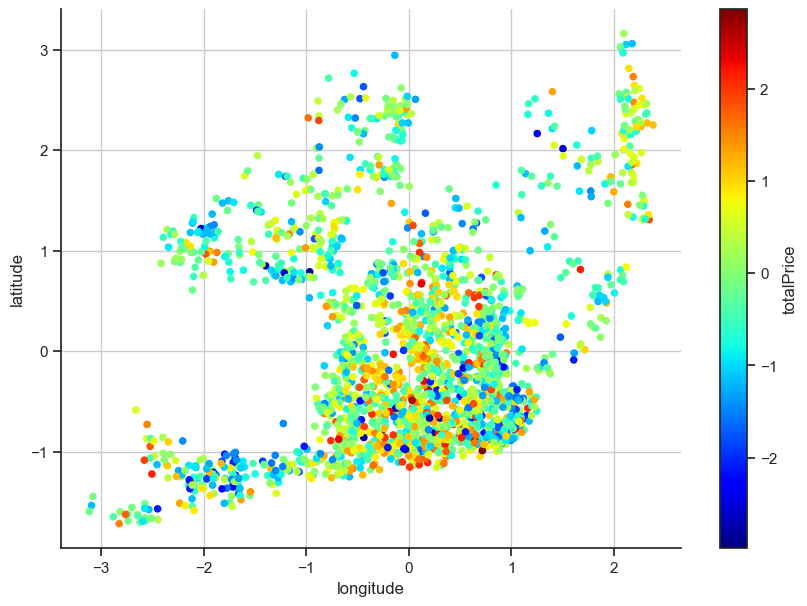

In [ ]:
data_train.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    c="totalPrice",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)
plt.show()

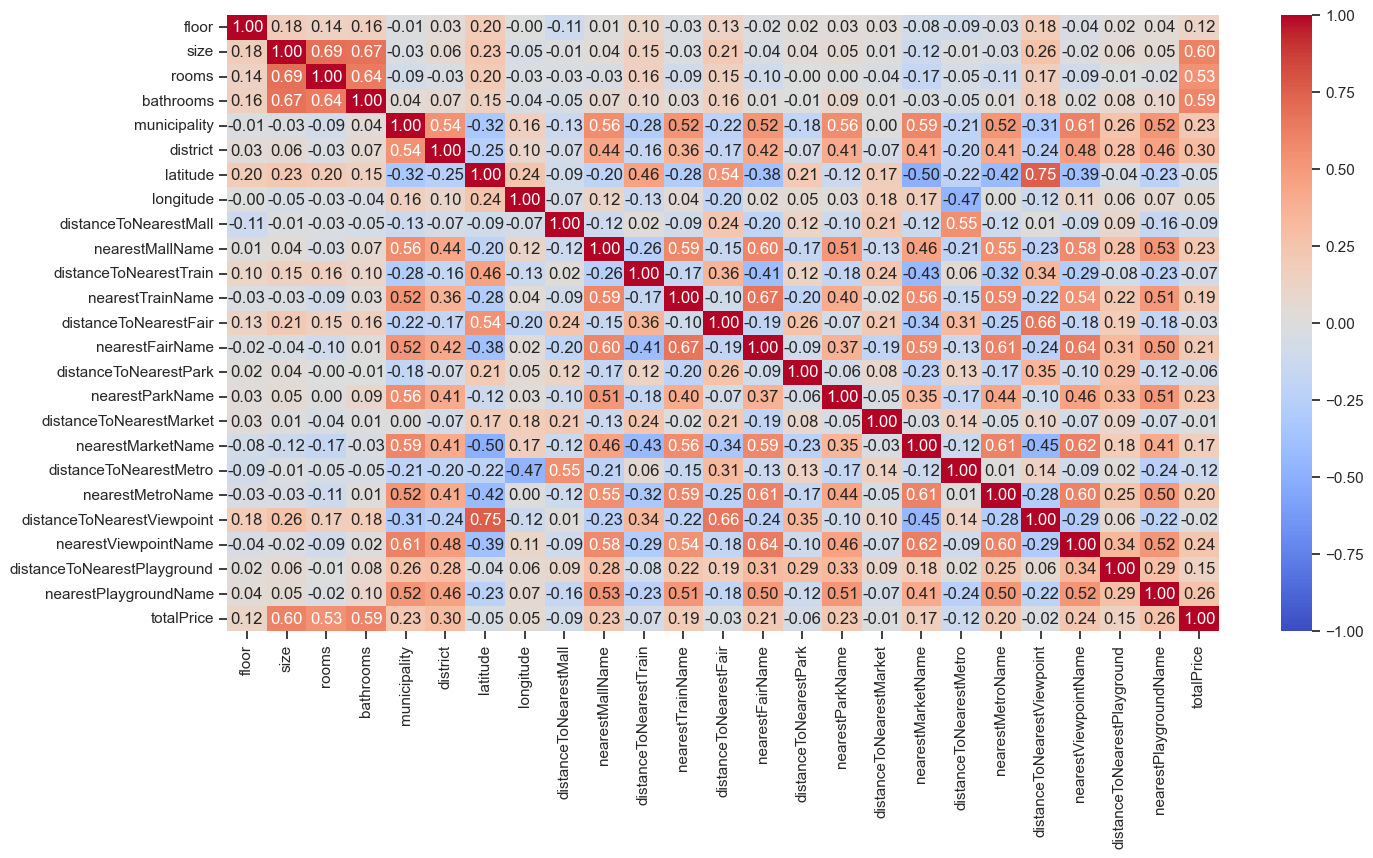

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    data_train[non_binary_vars + target].corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmax=1,
    vmin=-1,
)
plt.show()

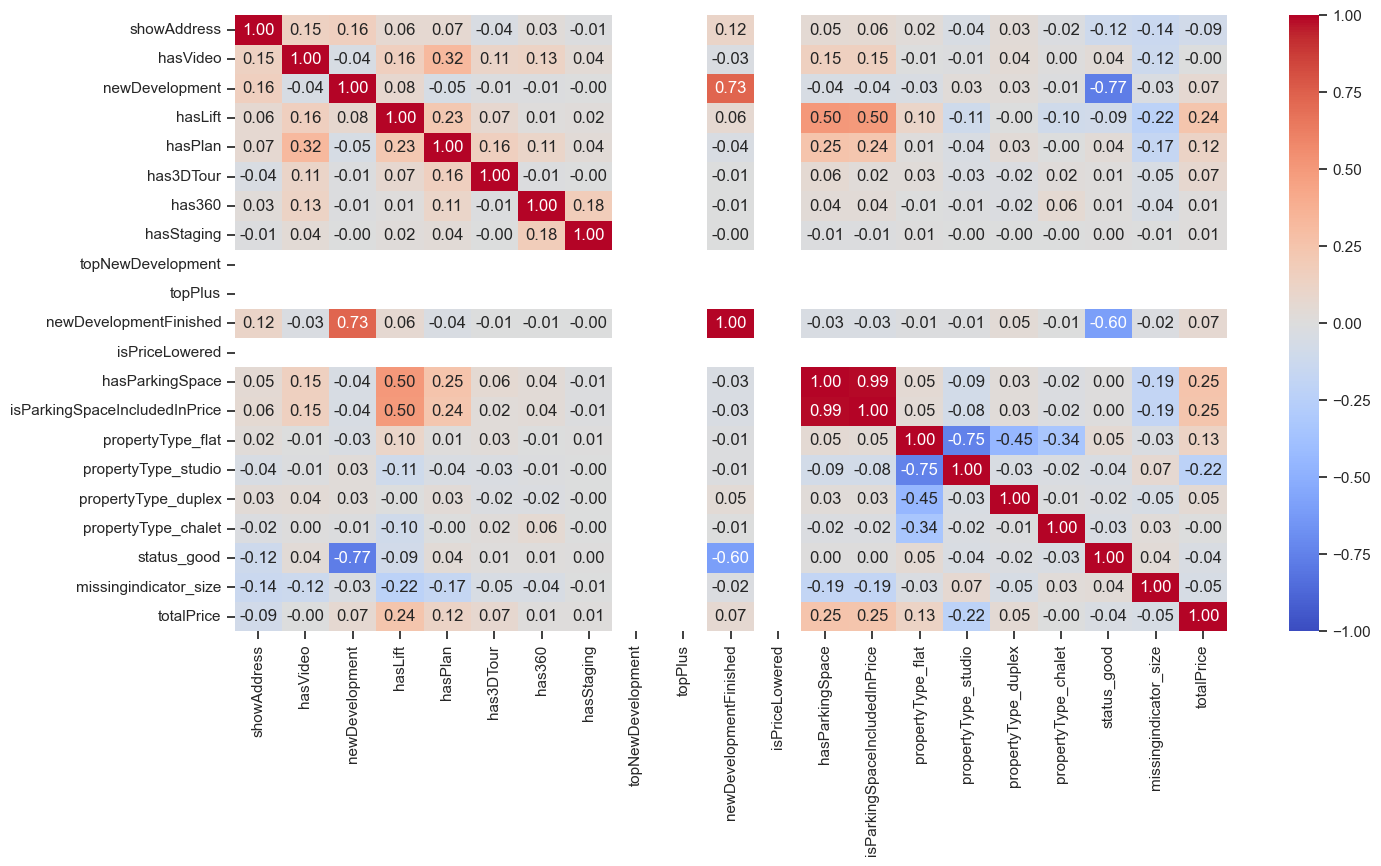

In [ ]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    data_train[binary_vars + target].corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmax=1,
    vmin=-1,
)
plt.show()

In [ ]:
temp = data_train.copy()
temp = temp.drop(columns=target)
all(temp.columns == features)

True

In [ ]:
X_train = data_train[features]
y_train = data_train[target]

In [ ]:
X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
from sklearn.linear_model import LinearRegression

# set up the model
lin_model = LinearRegression()

# train the model
lin_model.fit(X_train_dev, y_train_dev)

y_pred_dev = lin_model.predict(X_train_dev)
y_pred_val = lin_model.predict(X_val)

In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

# evaluate the model
root_mean_squared_error(y_train_dev, y_pred_dev), r2_score(y_train_dev, y_pred_dev)

(0.6135437636006684, 0.5867976043516703)

In [ ]:
root_mean_squared_error(y_val, y_pred_val), r2_score(y_val, y_pred_val)

(0.6649578246338043, 0.528372295674004)

In [ ]:
def plot_performance(model, X_train, y_train, X_test, y_test):
    # Define the range of the dependent variable
    y_train_min, y_train_max = y_train.values.min(), y_train.values.max()
    y_test_min, y_test_max = y_test.values.min(), y_test.values.max()
    var_range = [min(y_train_min, y_test_min), max(y_train_max, y_test_max)]
        
    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 4))
    
    # Plot train data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, color='royalblue', alpha=0.5, label='Train data')
    plt.plot(var_range, var_range, 'k--', lw=2)
    plt.xlabel(f'Actual price')
    plt.xlim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.ylabel(f'Predicted price')
    plt.ylim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.text(var_range[0], var_range[1] - 0.5, "RMSE = {:.3f}".format(root_mean_squared_error(y_train, y_train_pred)))
    plt.text(var_range[0], var_range[1] - 1, "R² = {:.3f}".format(r2_score(y_train, y_train_pred)))
    plt.legend(loc="lower right")
    
    # Plot test data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, color='lightskyblue', alpha=0.5, label='Test data')
    plt.plot(var_range, var_range, 'k--', lw=2)
    plt.xlabel(f'Actual price')
    plt.xlim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.ylabel(f'Predicted price')
    plt.ylim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.text(var_range[0], var_range[1] - 0.5, "RMSE = {:.3f}".format(root_mean_squared_error(y_test, y_test_pred)))
    plt.text(var_range[0], var_range[1] - 1, "R² = {:.3f}".format(r2_score(y_test, y_test_pred)))
    plt.legend(loc="lower right")
    
    plt.show()

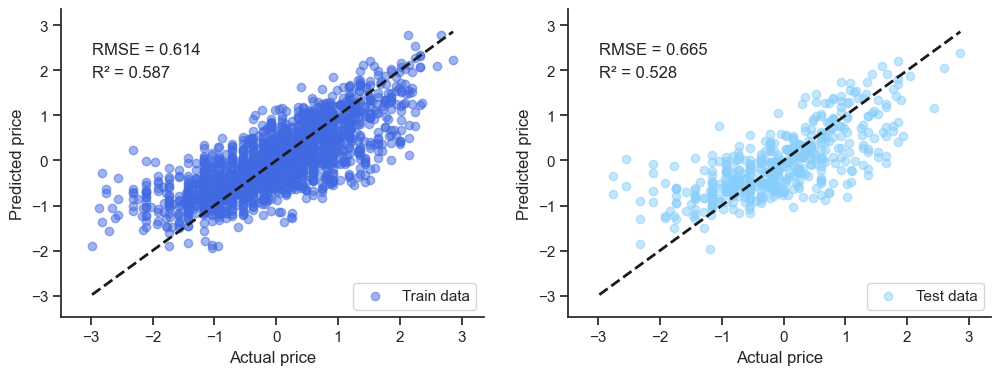

In [ ]:
plot_performance(lin_model, X_train_dev, y_train_dev, X_val, y_val)

In [ ]:
from sklearn.linear_model import ElasticNet

# set up the model
en_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)

# train the model
en_model.fit(X_train_dev, y_train_dev)

y_pred_dev = en_model.predict(X_train_dev)
y_pred_val = en_model.predict(X_val)

In [ ]:
root_mean_squared_error(y_train_dev, y_pred_dev), r2_score(y_train_dev, y_pred_dev)

(0.6175022121609167, 0.5814486238208627)

In [ ]:
root_mean_squared_error(y_val, y_pred_val), r2_score(y_val, y_pred_val)

(0.6637093958986663, 0.5301415533312583)

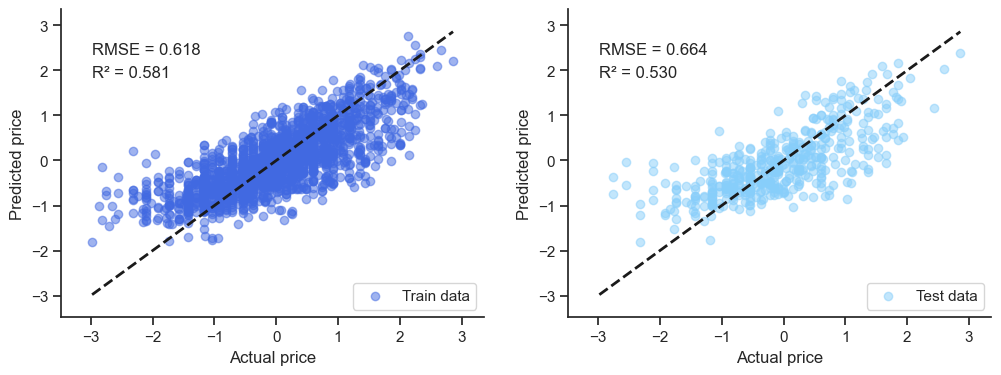

In [ ]:
plot_performance(en_model, X_train_dev, y_train_dev, X_val, y_val)

# Additional Resources

- [Feature Engineering for Machine Learning](https://www.trainindata_train.com/p/feature-engineering-for-machine-learning) - Online Course
- [Packt Feature Engineering Cookbook](https://www.amazon.com/Python-Feature-Engineering-Cookbook-transforming-dp-1804611301/dp/1804611301) - Book
- [Predict house price with Feature-engine](https://www.kaggle.com/solegalli/predict-house-price-with-feature-engine) - Kaggle kernel
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) - Kaggle kernel
- [How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition) - Kaggle kernel